# 변동성 목표 전략 + 모멘텀 전략

- 주식투자비중 = 변동성 목표 투자 비중x상대 모멘텀 비중 스코어

- 현금비중 = 1-주식투자 비중


In [1]:
from settings import * 

In [2]:
kospi = fdr.DataReader('KS11')[['Close']]

In [3]:
kospi

,Close
Date,
1981-05-01,123.600
1981-05-02,123.500
1981-05-04,120.600
1981-05-06,120.700
1981-05-07,119.300
...,...
2022-02-17,2744.090
2022-02-18,2744.520
2022-02-21,2743.800


In [4]:
s = '1985-1-30'
e = '2017-6-30'
# e = '2022-02-23'
start = '1986-1-31'

In [5]:
data_daily = pd.DataFrame()
data_daily['KOSPI'] = kospi.copy()
data_daily = data_daily[s:e]
# %%
dd = pd.DataFrame()
# dd.index = pd.date_range('1985', '2020-9-30', freq='D')
dd.index = pd.date_range(s, e, freq='D')
denominator = len(pd.date_range(s, e, freq='D'))/len(pd.date_range(s, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily = pd.merge(data_daily, dd, left_index=True, right_index=True, how='left')

In [6]:
data_daily

,KOSPI,현금
Date,,
1985-01-30,137.970,1.000
1985-01-31,138.900,1.000
1985-02-01,138.840,1.000
1985-02-02,138.480,1.000
1985-02-04,136.870,1.000
...,...,...
2017-06-26,2388.660,2.574
2017-06-27,2391.950,2.574
2017-06-28,2382.560,2.574


## 변동성 목표 전략 + 모멘텀 전략

%%
- 특정 기간 동안 투자 종목의 단위 투자 기간(일간, 주간, 월간)의 수익률을 각각 계산
- 구해진 수익률의 표준편차 계산
- 최종 투자 비중 = 제한하기를 원하는 손실 한계(변동성 목표) / 수익률 표준편차
- 나머지 투자 비중 = 현금 보유

## 변동성 목표 전략

In [7]:
# - 특정 기간 동안 투자 종목의 단위 투자 기간(일간, 주간, 월간)의 수익률을 각각 계산
# - 구해진 수익률의 표준편차 계산
# - 최종 투자 비중 = 제한하기를 원하는 손실 한계(변동성 목표) / 수익률 표준편차
# - 나머지 투자 비중 = 현금 보유

# XXX 필요하면 weights를 구해서 WeighTarget Algo로 해도 된다.
class WeighTargetVol(bt.Algo):
    """ 한개의 자산에 대해 즉 포트폴리오의 경우 그 결과에 대해서 TargetVol을 제어한다.

        자산 1개와 현금 1개로 구성된 prices DataFrame을 사용한다.
    """
    def __init__(self, targetvol=0.01, months=6, lag=pd.DateOffset(days=0), cash='현금'):
        super(WeighTargetVol, self).__init__()
        self.targetvol = targetvol
        self.lookback = months
        self.lag = lag
        self.cash = cash

    def __call__(self, target):
        selected = target.temp['selected'].copy()
        selected.remove(self.cash)
        
        prev_month = target.now #- pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False          

        # 월별 수익률의 변동성
        mret = prc.pct_change().dropna()
        std = mret.std()
#         print(std.values[0], mret)
    

        # H14 : std()
        # N$1 : targetvol
        # -------------------------------------------
        # =IF(H14>N$1, 
        # targetvol보다 변동성이 큰 경우
        #     N$1/H14 * B15/B14           <-- 주식 비중 TargetVol/RealVol
        #     +(1-N$1/H14)*1.03^(1/12),   <-- 현금 비중 (1 - 주식비중)
        # targetvol보다 변동성이 작은 경우
        #     B15/B14 투자비중 1인 경우
        #     )
        #     *K14 이전 수익률
        if std.values[0] > self.targetvol:
            weights = pd.Series(self.targetvol/std, index=selected)
        else:
            print("@@@ 몰빵!!!")
            weights = pd.Series(1.0, index=selected)
        weights[self.cash] = 1.0 - weights.sum()

        target.temp['weights'] = weights

        return True

In [8]:
def strategy_targetvol(name, data, start, targetvol=0.01, months=12, lag=pd.DateOffset(days=0), cash='현금'):
    s = bt.Strategy(name, 
            [
                bt.algos.RunMonthly(run_on_end_of_period=True), # 월말
                bt.algos.RunAfterDate(start),
                bt.algos.SelectAll(),
                #-------------------------------------------
                WeighTargetVol(targetvol, months, lag, cash),
                #-------------------------------------------
                PrintTempWeights(),
                bt.algos.Rebalance()
            ]
    )
    return bt.Backtest(s, data, initial_capital=100000000.0)

## 변동성 목표 + 모멘텀 전략

In [9]:
# XXX 필요하면 weights를 구해서 WeighTarget Algo로 해도 된다.
class WeighTargetVolWithAMS(bt.Algo):
    """ 한개의 자산에 대해 즉 포트폴리오의 경우 그 결과에 대해서 TargetVol을 제어한다.

        자산 1개와 현금 1개로 구성된 prices DataFrame을 사용한다.
    """
    def __init__(self, targetvol=0.01, months=12, lag=pd.DateOffset(days=0), cash_name='현금'):
        super(WeighTargetVolWithAMS, self).__init__()
        self.targetvol = targetvol
        self.lookback = months
        self.lag = lag
        self.cash_name = cash_name

    def average_momentum_score(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        if len(prc) != (self.lookback+1):
            raise ValueError(f"must be resample('M').last(), {prc}")
        ams = pd.Series(dtype='float64')
        for c in prc.columns:
            ams[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return ams

    def __call__(self, target):
        selected = target.temp['selected'].copy()
        selected.remove(self.cash_name)
        
        prev_month = target.now #- pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")


        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False            

        mret = prc.pct_change().dropna()
        std = mret.std()
#         print(std.values[0], mret)
    

        # H14 : std()
        # N$1 : targetvol
        # -------------------------------------------
        # =IF(H14>N$1, 
        # targetvol보다 변동성이 큰 경우
        #     N$1/H14 * B15/B14           <-- 주식 비중 TargetVol/RealVol
        #     +(1-N$1/H14)*1.03^(1/12),   <-- 현금 비중 (1 - 주식비중)
        # targetvol보다 변동성이 작은 경우
        #     B15/B14 투자비중 1인 경우
        #     )
        #     *K14 이전 수익률



        if std.values[0] > self.targetvol:
            print("==================", std.values[0], self.targetvol/std)
            weights = pd.Series(self.targetvol/std * self.average_momentum_score(prc), index=selected)
        else:
            weights = pd.Series(1.0, index=selected)
            
        weights[self.cash_name] = 1.0 - weights.sum()

        target.temp['weights'] = weights

        return True

In [10]:
def strategy_targetvol_with_ams(name, data, start, targetvol=0.01, months=12, lag=pd.DateOffset(days=0), cash_name='현금'):
    s = bt.Strategy(name, 
            [
                bt.algos.RunMonthly(run_on_end_of_period=True), # 월말
                bt.algos.RunAfterDate(start),
                bt.algos.SelectAll(),
                #-------------------------------------------
                WeighTargetVolWithAMS(targetvol, months, lag, cash_name),
                #-------------------------------------------
                PrintTempWeights(),
                bt.algos.Rebalance()
            ]
    )
    return bt.Backtest(s, data, initial_capital=100000000.0)

In [11]:
after_date = (datetime.strptime(start, '%Y-%m-%d') - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
after_date

'1986-01-30'

In [12]:
bt목표1모멘텀 = strategy_targetvol_with_ams("목표1%모멘텀", data_daily, after_date, targetvol=0.01)
r11 = bt.run(bt목표1모멘텀)


prc : 1986-01-31 00:00:00 1986-01 ~ 1985-01
================== 0.033931128301094585 KOSPI   0.295
dtype: float64
1986-01-31 00:00:00 목표1%모멘텀 KOSPI:0.270 현금:0.730 

prc : 1986-02-28 00:00:00 1986-02 ~ 1985-02
================== 0.03898288923689451 KOSPI   0.257
dtype: float64
1986-02-28 00:00:00 목표1%모멘텀 KOSPI:0.257 현금:0.743 

prc : 1986-03-31 00:00:00 1986-03 ~ 1985-03
================== 0.05042092643242135 KOSPI   0.198
dtype: float64
1986-03-31 00:00:00 목표1%모멘텀 KOSPI:0.198 현금:0.802 

prc : 1986-04-30 00:00:00 1986-04 ~ 1985-04
================== 0.04829450618156229 KOSPI   0.207
dtype: float64
1986-04-30 00:00:00 목표1%모멘텀 KOSPI:0.207 현금:0.793 

prc : 1986-05-31 00:00:00 1986-05 ~ 1985-05
================== 0.05497224641045268 KOSPI   0.182
dtype: float64
1986-05-31 00:00:00 목표1%모멘텀 KOSPI:0.182 현금:0.818 

prc : 1986-06-30 00:00:00 1986-06 ~ 1985-06
================== 0.054208351831098636 KOSPI   0.184
dtype: float64
1986-06-30 00:00:00 목표1%모멘텀 KOSPI:0.184 현금:0.816 

prc : 1986-07-31 00

In [13]:
r11.set_date_range(start)
r11.display()

Stat                 목표1%모멘텀
-------------------  --------------
Start                1986-01-31
End                  2017-06-30
Risk-free rate       0.00%

Total Return         273.08%
Daily Sharpe         1.69
Daily Sortino        2.74
CAGR                 4.28%
Max Drawdown         -4.25%
Calmar Ratio         1.01

MTD                  0.99%
3m                   6.51%
6m                   10.77%
YTD                  10.77%
1Y                   11.97%
3Y (ann.)            4.80%
5Y (ann.)            3.44%
10Y (ann.)           3.35%
Since Incep. (ann.)  4.28%

Daily Sharpe         1.69
Daily Sortino        2.74
Daily Mean (ann.)    4.00%
Daily Vol (ann.)     2.36%
Daily Skew           -0.24
Daily Kurt           7.68
Best Day             1.46%
Worst Day            -1.46%

Monthly Sharpe       1.57
Monthly Sortino      4.14
Monthly Mean (ann.)  4.23%
Monthly Vol (ann.)   2.70%
Monthly Skew         1.03
Monthly Kurt         3.48
Best Month           4.12%
Worst Month          -2.07%

Year

In [14]:
r11.prices.resample('M').last().to_drawdown_series().min()*100

목표1%모멘텀   -2.698
dtype: float64

In [15]:
bt목표1 = strategy_targetvol("목표1%", data_daily, after_date, targetvol=0.01)
r1 = bt.run(bt목표1)


prc : 1986-01-31 00:00:00 1986-01 ~ 1985-01
1986-01-31 00:00:00 목표1% KOSPI:0.295 현금:0.705 

prc : 1986-02-28 00:00:00 1986-02 ~ 1985-02
1986-02-28 00:00:00 목표1% KOSPI:0.257 현금:0.743 

prc : 1986-03-31 00:00:00 1986-03 ~ 1985-03
1986-03-31 00:00:00 목표1% KOSPI:0.198 현금:0.802 

prc : 1986-04-30 00:00:00 1986-04 ~ 1985-04
1986-04-30 00:00:00 목표1% KOSPI:0.207 현금:0.793 

prc : 1986-05-31 00:00:00 1986-05 ~ 1985-05
1986-05-31 00:00:00 목표1% KOSPI:0.182 현금:0.818 

prc : 1986-06-30 00:00:00 1986-06 ~ 1985-06
1986-06-30 00:00:00 목표1% KOSPI:0.184 현금:0.816 

prc : 1986-07-31 00:00:00 1986-07 ~ 1985-07
1986-07-31 00:00:00 목표1% KOSPI:0.178 현금:0.822 

prc : 1986-08-30 00:00:00 1986-08 ~ 1985-08
1986-08-30 00:00:00 목표1% KOSPI:0.168 현금:0.832 

prc : 1986-09-30 00:00:00 1986-09 ~ 1985-09
1986-09-30 00:00:00 목표1% KOSPI:0.153 현금:0.847 

prc : 1986-10-31 00:00:00 1986-10 ~ 1985-10
1986-10-31 00:00:00 목표1% KOSPI:0.140 현금:0.860 

prc : 1986-11-29 00:00:00 1986-11 ~ 1985-11
1986-11-29 00:00:00 목표1% KOSPI:0.13

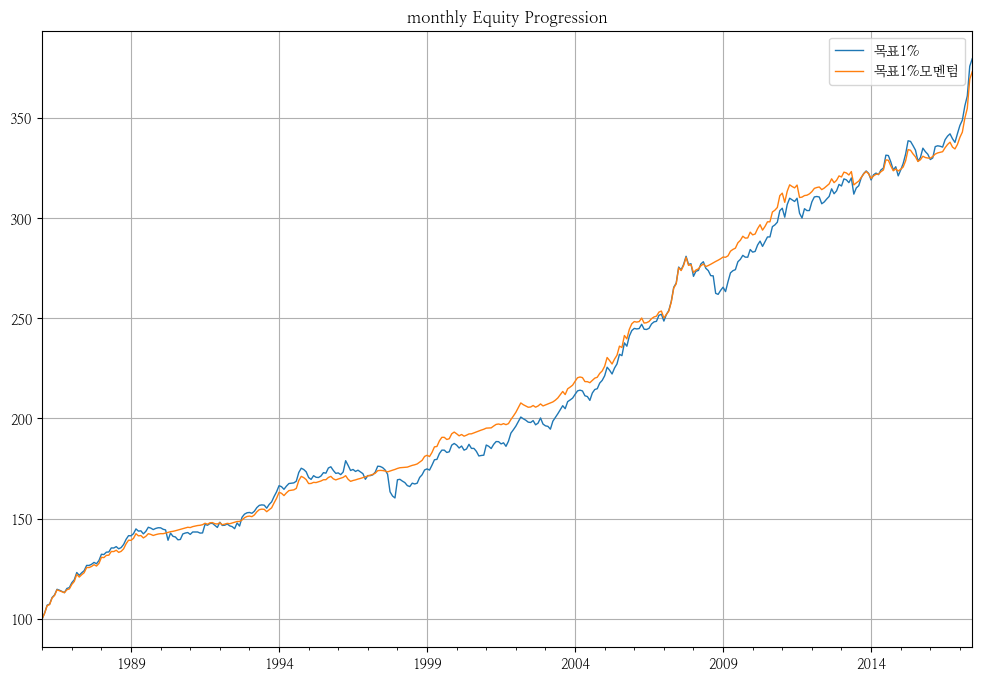

In [16]:
r1.set_date_range(start)

ax1 = r1.plot(freq='M', figsize=(12,8));
r11.plot(ax=ax1, freq='M', figsize=(12,8));

In [17]:
bt목표2모멘텀 = strategy_targetvol_with_ams("목표2%모멘텀", data_daily, start, targetvol=0.02)
r12 = bt.run(bt목표2모멘텀)


prc : 1986-02-28 00:00:00 1986-02 ~ 1985-02
================== 0.03898288923689451 KOSPI   0.513
dtype: float64
1986-02-28 00:00:00 목표2%모멘텀 KOSPI:0.513 현금:0.487 

prc : 1986-03-31 00:00:00 1986-03 ~ 1985-03
================== 0.05042092643242135 KOSPI   0.397
dtype: float64
1986-03-31 00:00:00 목표2%모멘텀 KOSPI:0.397 현금:0.603 

prc : 1986-04-30 00:00:00 1986-04 ~ 1985-04
================== 0.04829450618156229 KOSPI   0.414
dtype: float64
1986-04-30 00:00:00 목표2%모멘텀 KOSPI:0.414 현금:0.586 

prc : 1986-05-31 00:00:00 1986-05 ~ 1985-05
================== 0.05497224641045268 KOSPI   0.364
dtype: float64
1986-05-31 00:00:00 목표2%모멘텀 KOSPI:0.364 현금:0.636 

prc : 1986-06-30 00:00:00 1986-06 ~ 1985-06
================== 0.054208351831098636 KOSPI   0.369
dtype: float64
1986-06-30 00:00:00 목표2%모멘텀 KOSPI:0.369 현금:0.631 

prc : 1986-07-31 00:00:00 1986-07 ~ 1985-07
================== 0.05613592683611838 KOSPI   0.356
dtype: float64
1986-07-31 00:00:00 목표2%모멘텀 KOSPI:0.356 현금:0.644 

prc : 1986-08-30 00:

In [18]:
bt목표2 = strategy_targetvol("목표2%", data_daily, after_date, targetvol=0.02)
r목표2 = bt.run(bt목표2)


prc : 1986-01-31 00:00:00 1986-01 ~ 1985-01
1986-01-31 00:00:00 목표2% KOSPI:0.589 현금:0.411 

prc : 1986-02-28 00:00:00 1986-02 ~ 1985-02
1986-02-28 00:00:00 목표2% KOSPI:0.513 현금:0.487 

prc : 1986-03-31 00:00:00 1986-03 ~ 1985-03
1986-03-31 00:00:00 목표2% KOSPI:0.397 현금:0.603 

prc : 1986-04-30 00:00:00 1986-04 ~ 1985-04
1986-04-30 00:00:00 목표2% KOSPI:0.414 현금:0.586 

prc : 1986-05-31 00:00:00 1986-05 ~ 1985-05
1986-05-31 00:00:00 목표2% KOSPI:0.364 현금:0.636 

prc : 1986-06-30 00:00:00 1986-06 ~ 1985-06
1986-06-30 00:00:00 목표2% KOSPI:0.369 현금:0.631 

prc : 1986-07-31 00:00:00 1986-07 ~ 1985-07
1986-07-31 00:00:00 목표2% KOSPI:0.356 현금:0.644 

prc : 1986-08-30 00:00:00 1986-08 ~ 1985-08
1986-08-30 00:00:00 목표2% KOSPI:0.336 현금:0.664 

prc : 1986-09-30 00:00:00 1986-09 ~ 1985-09
1986-09-30 00:00:00 목표2% KOSPI:0.306 현금:0.694 

prc : 1986-10-31 00:00:00 1986-10 ~ 1985-10
1986-10-31 00:00:00 목표2% KOSPI:0.281 현금:0.719 

prc : 1986-11-29 00:00:00 1986-11 ~ 1985-11
1986-11-29 00:00:00 목표2% KOSPI:0.27

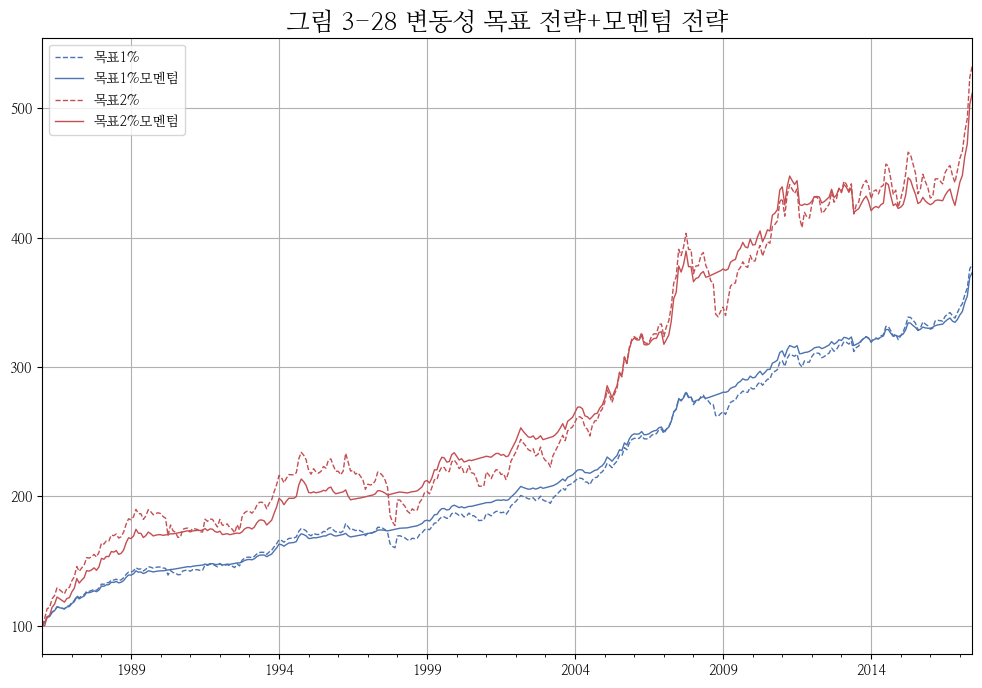

In [19]:
r목표1 = bt.run(bt목표1)
r목표2 = bt.run(bt목표2)
r목표1모멘텀 = bt.run(bt목표1모멘텀)
r목표2모멘텀 = bt.run(bt목표2모멘텀)
r목표1.set_date_range(start)
r목표2.set_date_range(start)
r목표1모멘텀.set_date_range(start)
r목표2모멘텀.set_date_range(start)

ax1 = r목표1.plot(freq='M', color='b', ls='--', figsize=(12, 8));
r목표1모멘텀.plot(ax=ax1, freq='M', color='b', ls='-', figsize=(12, 8));
r목표2.plot(ax=ax1, freq='M', color='r', ls='--', figsize=(12, 8));
r목표2모멘텀.plot(ax=ax1, freq='M', color='r', ls='-', figsize=(12, 8));
plt.title("그림 3-28 변동성 목표 전략+모멘텀 전략", fontsize=18);

In [20]:
r_all = bt.run(bt목표1, bt목표1모멘텀, bt목표2, bt목표2모멘텀)
r_all.set_date_range(start)
r_all.display()

Stat                 목표1%      목표1%모멘텀    목표2%      목표2%모멘텀
-------------------  ----------  --------------  ----------  --------------
Start                1986-01-31  1986-01-31      1986-01-31  1986-01-31
End                  2017-06-30  2017-06-30      2017-06-30  2017-06-30
Risk-free rate       0.00%       0.00%           0.00%       0.00%

Total Return         279.59%     273.08%         432.96%     411.71%
Daily Sharpe         1.14        1.69            0.74        1.07
Daily Sortino        1.91        2.74            1.22        1.69
CAGR                 4.34%       4.28%           5.47%       5.33%
Max Drawdown         -11.24%     -4.25%          -26.15%     -9.55%
Calmar Ratio         0.39        1.01            0.21        0.56

MTD                  0.99%       0.99%           1.74%       1.74%
3m                   6.51%       6.51%           10.33%      10.33%
6m                   10.94%      10.77%          17.85%      17.85%
YTD                  10.94%      10.77%       

In [21]:
r_all.prices.resample('M').last().to_drawdown_series().min()*100

목표1%      -10.405
목표1%모멘텀    -2.698
목표2%      -24.167
목표2%모멘텀    -7.550
dtype: float64

         CAGR
목표1%    4.338
목표1%모멘텀 4.281
목표2%    5.471
목표2%모멘텀 5.335
            MDD
목표1%    -11.241
목표1%모멘텀  -4.252
목표2%    -26.151
목표2%모멘텀  -9.545


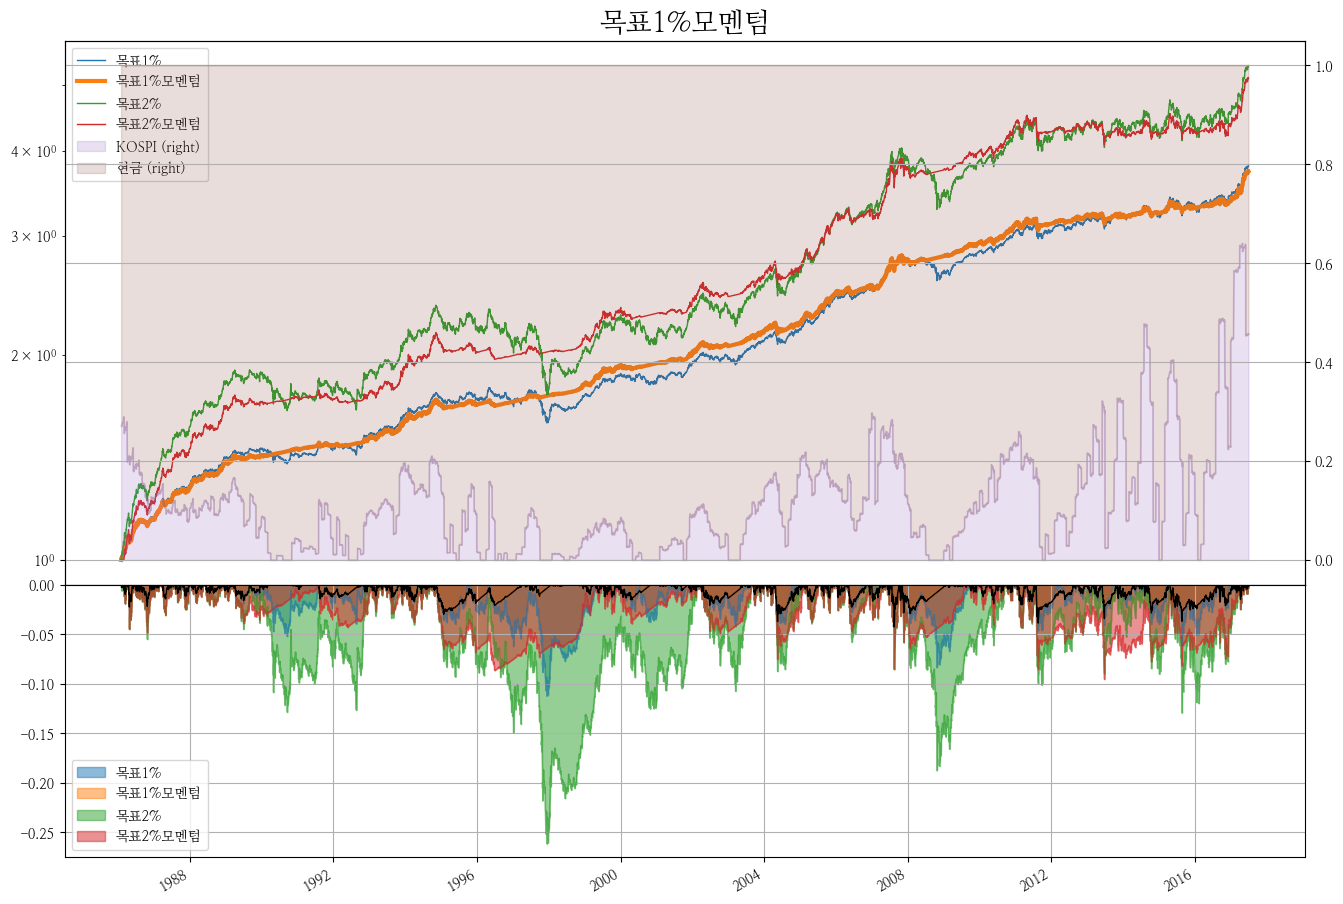

In [22]:
plot_assets(r_all, start, e, "목표1%모멘텀")